# Estimación de ruido mediante análisis del histograma

In [2]:
import numpy as np
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.stats import norm
%load_ext autoreload
%autoreload 2
%matplotlib inline

Leemos la data extraida del slice

In [3]:
data_path = 'infosaves'
with open(rf"infosaves/100.0_100.0_253x263.json") as f:
    stats = json.load(f)
stats

{'nombre_img': '100.0_100.0_253x263',
 'altura': 253,
 'width': 263,
 'varianza': 148.0590359989778,
 'mean': 15.669892844797788}

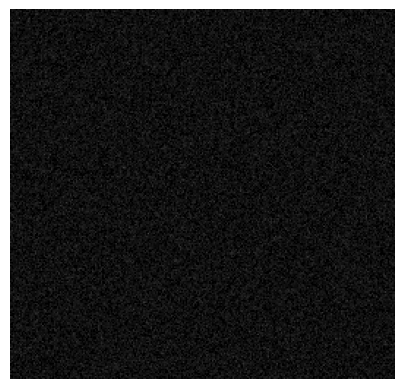

In [4]:
img_ruido = np.random.normal(loc=stats['mean'], 
                             scale=np.sqrt(stats['varianza']),
                             size=(stats['altura'], stats['width']))
plt.imshow(img_ruido, vmin=0, vmax=255, cmap='gray')
plt.axis('off')
plt.show()

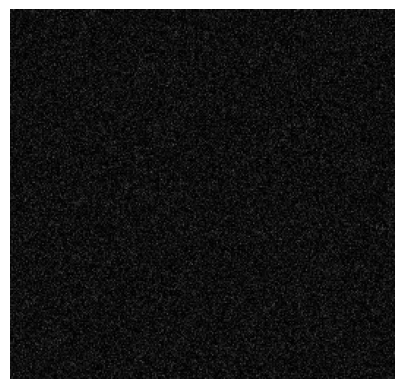

In [5]:
ruido = cv2.imread('PAIByB-1/Noise-1.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(ruido[:stats['altura'], :stats['width']], vmin=0, vmax=255, cmap='gray')
plt.axis('off')
plt.show()

### Ahora, con el histograma

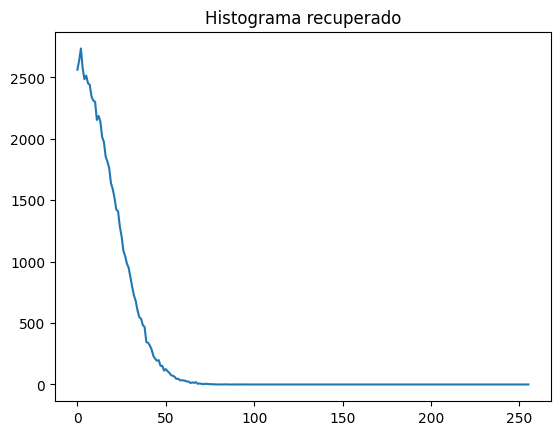

In [6]:
hist_df = pd.read_csv(f"infosaves/hist100.0_100.0_253x263.csv")

fig, ax = plt.subplots()
ax.plot(hist_df['gray_lvl'], hist_df['hist_value'])
ax.set_title('Histograma recuperado')
plt.show()

### Ajustamos una distribución normal por análisis estadístico del histograma

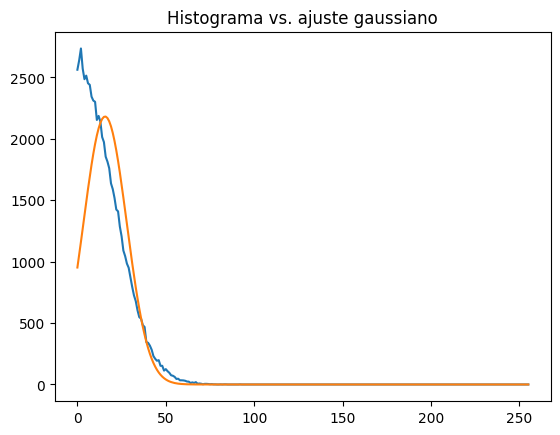

In [10]:
I, h = hist_df['gray_lvl'], hist_df['hist_value']
mu = np.dot(I, h) / h.sum()
sigma = np.sqrt(np.dot((I - mu)**2, h) / h.sum())
bell_curve = norm.pdf(x=I, loc=mu, scale=sigma) * h.sum()

fig, ax = plt.subplots()
ax.plot(hist_df['gray_lvl'], hist_df['hist_value'])
ax.plot(hist_df['gray_lvl'], bell_curve)
ax.set_title('Histograma vs. ajuste gaussiano')
plt.show()

In [11]:
# Calculo DMA
dma = np.abs(I - mu).dot(h) / h.sum()
print(f"{dma=:.3f}")

dma=9.750


## Fourier

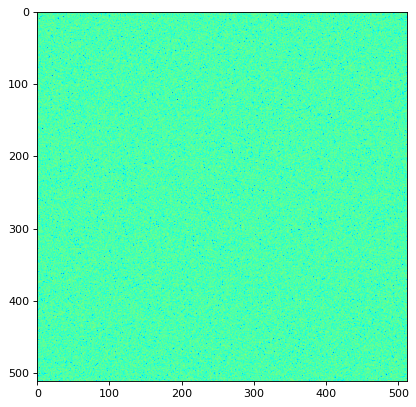

In [17]:
img = cv2.imread('PAIByB-1/Noise.tif',cv2.IMREAD_GRAYSCALE)

img_psd = np.abs(np.fft.fftshift(np.fft.fft2(img)))**2

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(img_psd), cmap='jet')
plt.show()

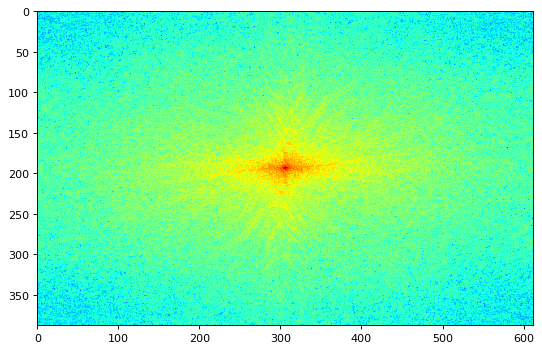

In [18]:
img = cv2.imread('PAIByB-2/Pie2-1.tif',cv2.IMREAD_GRAYSCALE)

img_psd = np.abs(np.fft.fftshift(np.fft.fft2(img)))**2

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(img_psd), cmap='jet')
plt.show()